In [73]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Reshape, Concatenate, Flatten, Lambda
from keras.models import Model
from keras.losses import binary_crossentropy, kullback_leibler_divergence
from keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import json
import glob
from sklearn.model_selection import train_test_split
import numpy as np
from io import BytesIO
import PIL
from IPython.display import clear_output, Image, display, HTML

In [2]:
def load_icons(train_size=0.85):
    icon_index = json.load(open('icons/index.json'))
    x = []
    img_rows, img_cols = 32, 32
    for icon in icon_index:
        if icon['name'].endswith('_filled'):
            continue
        img_path = 'icons/png32/%s.png' % icon['name']
        img = load_img(img_path, grayscale=True, target_size=(img_rows, img_cols))
        img = img_to_array(img)
        x.append(img)
    x = np.asarray(x) / 255
    x_train, x_val = train_test_split(x, train_size=train_size)
    return x_train, x_val

x_train, x_test = load_icons()
x_train.shape, x_test.shape

((3937, 32, 32, 1), (695, 32, 32, 1))

In [3]:
x_train.shape

(3937, 32, 32, 1)

In [9]:
def create_autoencoder():
    input_img = Input(shape=(32, 32, 1))

    channels = 4
    x = input_img
    for i in range(5):
        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)
        channels *= 2

    x = Dense(channels)(x)

    for i in range(5):
        x = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        channels //= 2
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return autoencoder

autoencoder = create_autoencoder()
autoencoder.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 32, 32, 1)     0                                            
____________________________________________________________________________________________________
conv2d_30 (Conv2D)               (None, 32, 32, 4)     40                                           
____________________________________________________________________________________________________
conv2d_31 (Conv2D)               (None, 32, 32, 4)     20                                           
____________________________________________________________________________________________________
concatenate_10 (Concatenate)     (None, 32, 32, 8)     0                                            
___________________________________________________________________________________________

In [10]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 3937 samples, validate on 695 samples
Epoch 1/100
3937/3937 [==============================] - 0s - loss: 0.6032 - val_loss: 0.5559
Epoch 2/100
3937/3937 [==============================] - 0s - loss: 0.5370 - val_loss: 0.5651
Epoch 3/100
3937/3937 [==============================] - 0s - loss: 0.5161 - val_loss: 0.5061
Epoch 4/100
3937/3937 [==============================] - 0s - loss: 0.5079 - val_loss: 0.5111
Epoch 5/100
3937/3937 [==============================] - 0s - loss: 0.5057 - val_loss: 0.5036
Epoch 6/100
3937/3937 [==============================] - 0s - loss: 0.5006 - val_loss: 0.5105
Epoch 7/100
3937/3937 [==============================] - 0s - loss: 0.5011 - val_loss: 0.4999
Epoch 8/100
3937/3937 [==============================] - 0s - loss: 0.4975 - val_loss: 0.5003
Epoch 9/100
3937/3937 [==============================] - 0s - loss: 0.4983 - val_loss: 0.4979
Epoch 10/100
3937/3937 [==============================] - 0s - loss: 0.4982 - val_loss: 0.5027
Epoch 11/100

3937/3937 [==============================] - 0s - loss: 0.3927 - val_loss: 0.3978
Epoch 87/100
3937/3937 [==============================] - 0s - loss: 0.3916 - val_loss: 0.3927
Epoch 88/100
3937/3937 [==============================] - 0s - loss: 0.3926 - val_loss: 0.4009
Epoch 89/100
3937/3937 [==============================] - 0s - loss: 0.3911 - val_loss: 0.3929
Epoch 90/100
3937/3937 [==============================] - 0s - loss: 0.3904 - val_loss: 0.3900
Epoch 91/100
3937/3937 [==============================] - 0s - loss: 0.3895 - val_loss: 0.3906
Epoch 92/100
3937/3937 [==============================] - 0s - loss: 0.3892 - val_loss: 0.3959
Epoch 93/100
3937/3937 [==============================] - 0s - loss: 0.3891 - val_loss: 0.3940
Epoch 94/100
3937/3937 [==============================] - 0s - loss: 0.3889 - val_loss: 0.3901
Epoch 95/100
3937/3937 [==============================] - 0s - loss: 0.3871 - val_loss: 0.3960
Epoch 96/100
3937/3937 [==============================] - 0s - 

In [11]:
cols = 25
idx = np.random.randint(x_test.shape[0], size=cols)
sample = x_test[idx]
decoded_imgs = autoencoder.predict(sample)
decoded_imgs.shape

(25, 32, 32, 1)

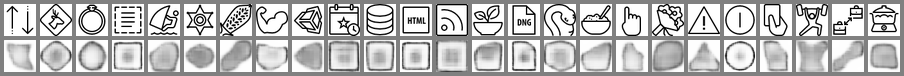

In [12]:
def decode_img(tile):
    tile = tile.reshape(tile.shape[:-1])
    tile = np.clip(tile * 255, 0, 255)
    return PIL.Image.fromarray(tile)
    

overview = PIL.Image.new('RGB', (cols * 36 + 4, 64 + 12), (128, 128, 128))
for idx in range(cols):
    overview.paste(decode_img(sample[idx]), (idx * 36 + 4, 4))
    overview.paste(decode_img(decoded_imgs[idx]), (idx * 36 + 4, 40))
f = BytesIO()
overview.save(f, 'png')
display(Image(data=f.getvalue()))



In [13]:
def augment(icons):
    aug_icons = []
    for icon in icons:
        for flip in range(4):
            for rotation in range(4):
                aug_icons.append(icon)
                icon = np.rot90(icon)
            icon = np.fliplr(icon)
    return np.asarray(aug_icons)


In [36]:
x_train_aug = augment(x_train)
x_test_aug = augment(x_test)

In [37]:
x_train_aug.shape

(62992, 32, 32, 1)

In [16]:
from keras.callbacks import TensorBoard
autoencoder = create_autoencoder()
autoencoder.fit(x_train_aug, x_train_aug,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_aug, x_test_aug),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 62992 samples, validate on 11120 samples
Epoch 1/100
62992/62992 [==============================] - 5s - loss: 0.5095 - val_loss: 0.5130
Epoch 2/100
62992/62992 [==============================] - 5s - loss: 0.4824 - val_loss: 0.4658
Epoch 3/100
62992/62992 [==============================] - 5s - loss: 0.4529 - val_loss: 0.4454
Epoch 4/100
62992/62992 [==============================] - 5s - loss: 0.4302 - val_loss: 0.4283
Epoch 5/100
62992/62992 [==============================] - 5s - loss: 0.4135 - val_loss: 0.4249
Epoch 6/100
62992/62992 [==============================] - 5s - loss: 0.4013 - val_loss: 0.3980
Epoch 7/100
62992/62992 [==============================] - 5s - loss: 0.3920 - val_loss: 0.3942
Epoch 8/100
62992/62992 [==============================] - 5s - loss: 0.3856 - val_loss: 0.3889
Epoch 9/100
62992/62992 [==============================] - 5s - loss: 0.3807 - val_loss: 0.3866
Epoch 10/100
62992/62992 [==============================] - 5s - loss: 0.3768 - val_lo

62992/62992 [==============================] - 5s - loss: 0.3065 - val_loss: 0.3229
Epoch 86/100
62992/62992 [==============================] - 5s - loss: 0.3062 - val_loss: 0.3185
Epoch 87/100
62992/62992 [==============================] - 5s - loss: 0.3058 - val_loss: 0.3178
Epoch 88/100
62992/62992 [==============================] - 5s - loss: 0.3057 - val_loss: 0.3188
Epoch 89/100
62992/62992 [==============================] - 5s - loss: 0.3053 - val_loss: 0.3189
Epoch 90/100
62992/62992 [==============================] - 5s - loss: 0.3051 - val_loss: 0.3209
Epoch 91/100
62992/62992 [==============================] - 5s - loss: 0.3049 - val_loss: 0.3228
Epoch 92/100
62992/62992 [==============================] - 5s - loss: 0.3044 - val_loss: 0.3144
Epoch 93/100
62992/62992 [==============================] - 5s - loss: 0.3042 - val_loss: 0.3253
Epoch 94/100
62992/62992 [==============================] - 5s - loss: 0.3038 - val_loss: 0.3133
Epoch 95/100
62992/62992 [=================

In [17]:
cols = 25
idx = np.random.randint(x_test.shape[0], size=cols)
sample = x_test[idx]
decoded_imgs = autoencoder.predict(sample)
decoded_imgs.shape

(25, 32, 32, 1)

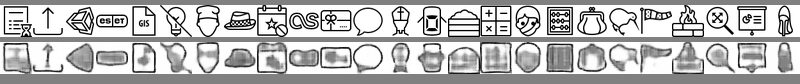

In [18]:
def decode_img(tile, factor=1.0):
    tile = tile.reshape(tile.shape[:-1])
    tile = np.clip(tile * 255, 0, 255)
    return PIL.Image.fromarray(tile)
    

overview = PIL.Image.new('RGB', (cols * 32, 64 + 20), (128, 128, 128))
for idx in range(cols):
    overview.paste(decode_img(sample[idx]), (idx * 32, 5))
    overview.paste(decode_img(decoded_imgs[idx]), (idx * 32, 42))
f = BytesIO()
overview.save(f, 'png')
display(Image(data=f.getvalue()))



In [19]:
batch_size = 250
latent_space_depth = 128

def sample_z(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=(batch_size, latent_space_depth), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * eps

In [158]:
def VariationalAutoEncoder(num_pixels):
    
    input_img = Input(shape=(32, 32, 1))

    channels = 4
    x = input_img
    for i in range(5):
        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)
        channels *= 2

    x = Dense(channels)(x)
    encoder_hidden = Flatten()(x)

    z_mean = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    z_log_var = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    
    def KL_loss(y_true, y_pred):
        return 0.0001 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=1)

    def reconstruction_loss(y_true, y_pred):
        y_true = K.batch_flatten(y_true)
        y_pred = K.batch_flatten(y_pred)
        return binary_crossentropy(y_true, y_pred)

    def total_loss(y_true, y_pred):
        return reconstruction_loss(y_true, y_pred) + KL_loss(y_true, y_pred)

    z = Lambda(sample_z, output_shape=(latent_space_depth, ))([z_mean, z_log_var])
    decoder_in = Input(shape=(latent_space_depth,))

    d_x = Reshape((1, 1, latent_space_depth))(decoder_in)
    e_x = Reshape((1, 1, latent_space_depth))(z)
    for i in range(5):
        conv = Conv2D(channels, (3, 3), activation='relu', padding='same')
        upsampling = UpSampling2D((2, 2))
        d_x = conv(d_x)
        d_x = upsampling(d_x)
        e_x = conv(e_x)
        e_x = upsampling(e_x)
        channels //= 2

    final_conv = Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    auto_decoded = final_conv(e_x)
    decoder_out = final_conv(d_x)
    
    decoder = Model(decoder_in, decoder_out)    
    
    auto_encoder = Model(input_img, auto_decoded)

    auto_encoder.compile(optimizer=Adam(lr=0.001), 
                         loss=total_loss,
                         metrics=[KL_loss, reconstruction_loss])
    
    return auto_encoder, decoder

var_auto_encoder, decoder = VariationalAutoEncoder(32)
var_auto_encoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_55 (InputLayer)            (None, 32, 32, 1)     0                                            
____________________________________________________________________________________________________
conv2d_465 (Conv2D)              (None, 32, 32, 4)     40                                           
____________________________________________________________________________________________________
conv2d_466 (Conv2D)              (None, 32, 32, 4)     20                                           
____________________________________________________________________________________________________
concatenate_155 (Concatenate)    (None, 32, 32, 8)     0                                            
___________________________________________________________________________________________

In [159]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        (None, 128)               0         
_________________________________________________________________
reshape_45 (Reshape)         (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_475 (Conv2D)          (None, 1, 1, 128)         147584    
_________________________________________________________________
up_sampling2d_131 (UpSamplin (None, 2, 2, 128)         0         
_________________________________________________________________
conv2d_476 (Conv2D)          (None, 2, 2, 64)          73792     
_________________________________________________________________
up_sampling2d_132 (UpSamplin (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_477 (Conv2D)          (None, 4, 4, 32)          18464     
__________

In [160]:
def truncate_to_batch(x):
    l = x.shape[0]
    return x[:l - l % batch_size, :, :, :]

x_train_trunc = truncate_to_batch(x_train)
x_test_trunc = truncate_to_batch(x_test)
x_train_trunc.shape, x_test_trunc.shape

((3750, 32, 32, 1), (500, 32, 32, 1))

In [161]:
var_auto_encoder.fit(x_train_trunc, x_train_trunc, verbose=1, 
                 batch_size=batch_size, epochs=100,
                 validation_data=(x_test_trunc, x_test_trunc))

Train on 3750 samples, validate on 500 samples
Epoch 1/100
3750/3750 [==============================] - 1s - loss: 0.5771 - KL_loss: 2.7625e-04 - reconstruction_loss: 0.5768 - val_loss: 0.5455 - val_KL_loss: 4.2084e-05 - val_reconstruction_loss: 0.5454
Epoch 2/100
3750/3750 [==============================] - 0s - loss: 0.5274 - KL_loss: 3.1445e-05 - reconstruction_loss: 0.5273 - val_loss: 0.5249 - val_KL_loss: 2.5529e-05 - val_reconstruction_loss: 0.5249
Epoch 3/100
3750/3750 [==============================] - 0s - loss: 0.5129 - KL_loss: 2.1664e-05 - reconstruction_loss: 0.5129 - val_loss: 0.5129 - val_KL_loss: 1.8901e-05 - val_reconstruction_loss: 0.5129
Epoch 4/100
3750/3750 [==============================] - 0s - loss: 0.5041 - KL_loss: 2.0849e-05 - reconstruction_loss: 0.5041 - val_loss: 0.5084 - val_KL_loss: 3.5252e-05 - val_reconstruction_loss: 0.5084
Epoch 5/100
3750/3750 [==============================] - 0s - loss: 0.4979 - KL_loss: 2.6181e-04 - reconstruction_loss: 0.4976 - 

3750/3750 [==============================] - 0s - loss: 0.4155 - KL_loss: 0.0058 - reconstruction_loss: 0.4097 - val_loss: 0.4187 - val_KL_loss: 0.0058 - val_reconstruction_loss: 0.4128
Epoch 42/100
3750/3750 [==============================] - 0s - loss: 0.4145 - KL_loss: 0.0059 - reconstruction_loss: 0.4086 - val_loss: 0.4180 - val_KL_loss: 0.0061 - val_reconstruction_loss: 0.4119
Epoch 43/100
3750/3750 [==============================] - 0s - loss: 0.4140 - KL_loss: 0.0060 - reconstruction_loss: 0.4081 - val_loss: 0.4179 - val_KL_loss: 0.0061 - val_reconstruction_loss: 0.4118
Epoch 44/100
3750/3750 [==============================] - 0s - loss: 0.4127 - KL_loss: 0.0059 - reconstruction_loss: 0.4067 - val_loss: 0.4157 - val_KL_loss: 0.0062 - val_reconstruction_loss: 0.4096
Epoch 45/100
3750/3750 [==============================] - 0s - loss: 0.4113 - KL_loss: 0.0060 - reconstruction_loss: 0.4053 - val_loss: 0.4153 - val_KL_loss: 0.0063 - val_reconstruction_loss: 0.4091
Epoch 46/100
3750/

3750/3750 [==============================] - 0s - loss: 0.3792 - KL_loss: 0.0079 - reconstruction_loss: 0.3713 - val_loss: 0.3894 - val_KL_loss: 0.0078 - val_reconstruction_loss: 0.3816
Epoch 83/100
3750/3750 [==============================] - 0s - loss: 0.3790 - KL_loss: 0.0078 - reconstruction_loss: 0.3712 - val_loss: 0.3900 - val_KL_loss: 0.0079 - val_reconstruction_loss: 0.3821
Epoch 84/100
3750/3750 [==============================] - 0s - loss: 0.3787 - KL_loss: 0.0079 - reconstruction_loss: 0.3708 - val_loss: 0.3884 - val_KL_loss: 0.0078 - val_reconstruction_loss: 0.3806
Epoch 85/100
3750/3750 [==============================] - 0s - loss: 0.3774 - KL_loss: 0.0078 - reconstruction_loss: 0.3696 - val_loss: 0.3886 - val_KL_loss: 0.0079 - val_reconstruction_loss: 0.3807
Epoch 86/100
3750/3750 [==============================] - 0s - loss: 0.3770 - KL_loss: 0.0079 - reconstruction_loss: 0.3691 - val_loss: 0.3871 - val_KL_loss: 0.0079 - val_reconstruction_loss: 0.3792
Epoch 87/100
3750/

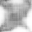

In [162]:
random_number = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
img_width, img_height = 32, 32
def decode_img(a):
    a = np.clip(a * 256, 0, 255).astype('uint8')
    return PIL.Image.fromarray(a)

decode_img(decoder.predict(random_number).reshape(img_width, img_height))


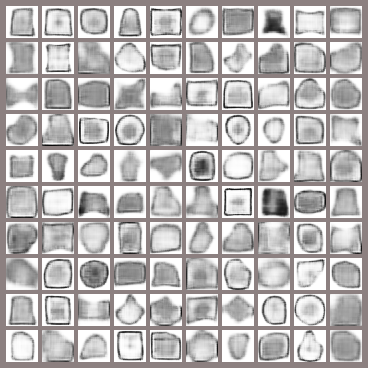

In [163]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))
for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[np.random.normal() * 1.4 
                            for _ in range(latent_space_depth)]])
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

In [164]:
def truncate_to_batch(x):
    l = x.shape[0]
    return x[:l - l % batch_size, :, :, :]

x_train_trunc = truncate_to_batch(x_train_aug)
x_test_trunc = truncate_to_batch(x_test_aug)
x_train_trunc.shape, x_test_trunc.shape

var_auto_encoder.fit(x_train_trunc, x_train_trunc, verbose=1, 
                 batch_size=batch_size, epochs=100,
                 validation_data=(x_test_trunc, x_test_trunc))

Train on 62750 samples, validate on 11000 samples
Epoch 1/100
62750/62750 [==============================] - 4s - loss: 0.3844 - KL_loss: 0.0075 - reconstruction_loss: 0.3769 - val_loss: 0.3844 - val_KL_loss: 0.0075 - val_reconstruction_loss: 0.3769
Epoch 2/100
62750/62750 [==============================] - 4s - loss: 0.3778 - KL_loss: 0.0076 - reconstruction_loss: 0.3702 - val_loss: 0.3795 - val_KL_loss: 0.0077 - val_reconstruction_loss: 0.3719
Epoch 3/100
62750/62750 [==============================] - 4s - loss: 0.3731 - KL_loss: 0.0076 - reconstruction_loss: 0.3655 - val_loss: 0.3757 - val_KL_loss: 0.0077 - val_reconstruction_loss: 0.3680
Epoch 4/100
62750/62750 [==============================] - 4s - loss: 0.3694 - KL_loss: 0.0077 - reconstruction_loss: 0.3617 - val_loss: 0.3722 - val_KL_loss: 0.0078 - val_reconstruction_loss: 0.3645
Epoch 5/100
62750/62750 [==============================] - 4s - loss: 0.3664 - KL_loss: 0.0078 - reconstruction_loss: 0.3586 - val_loss: 0.3703 - val_

62750/62750 [==============================] - 4s - loss: 0.3355 - KL_loss: 0.0097 - reconstruction_loss: 0.3258 - val_loss: 0.3452 - val_KL_loss: 0.0097 - val_reconstruction_loss: 0.3354
Epoch 42/100
62750/62750 [==============================] - 4s - loss: 0.3352 - KL_loss: 0.0097 - reconstruction_loss: 0.3255 - val_loss: 0.3454 - val_KL_loss: 0.0098 - val_reconstruction_loss: 0.3355
Epoch 43/100
62750/62750 [==============================] - 4s - loss: 0.3347 - KL_loss: 0.0098 - reconstruction_loss: 0.3249 - val_loss: 0.3445 - val_KL_loss: 0.0097 - val_reconstruction_loss: 0.3348
Epoch 44/100
62750/62750 [==============================] - 4s - loss: 0.3344 - KL_loss: 0.0098 - reconstruction_loss: 0.3246 - val_loss: 0.3455 - val_KL_loss: 0.0099 - val_reconstruction_loss: 0.3357
Epoch 45/100
62750/62750 [==============================] - 4s - loss: 0.3343 - KL_loss: 0.0098 - reconstruction_loss: 0.3245 - val_loss: 0.3448 - val_KL_loss: 0.0099 - val_reconstruction_loss: 0.3349
Epoch 46

62750/62750 [==============================] - 4s - loss: 0.3268 - KL_loss: 0.0103 - reconstruction_loss: 0.3166 - val_loss: 0.3392 - val_KL_loss: 0.0103 - val_reconstruction_loss: 0.3289
Epoch 82/100
62750/62750 [==============================] - 4s - loss: 0.3268 - KL_loss: 0.0103 - reconstruction_loss: 0.3165 - val_loss: 0.3390 - val_KL_loss: 0.0101 - val_reconstruction_loss: 0.3289
Epoch 83/100
62750/62750 [==============================] - 4s - loss: 0.3265 - KL_loss: 0.0103 - reconstruction_loss: 0.3162 - val_loss: 0.3389 - val_KL_loss: 0.0103 - val_reconstruction_loss: 0.3287
Epoch 84/100
62750/62750 [==============================] - 4s - loss: 0.3265 - KL_loss: 0.0103 - reconstruction_loss: 0.3162 - val_loss: 0.3392 - val_KL_loss: 0.0105 - val_reconstruction_loss: 0.3288
Epoch 85/100
62750/62750 [==============================] - 4s - loss: 0.3264 - KL_loss: 0.0103 - reconstruction_loss: 0.3160 - val_loss: 0.3392 - val_KL_loss: 0.0104 - val_reconstruction_loss: 0.3288
Epoch 86

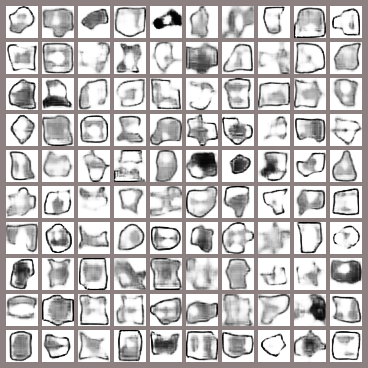

In [168]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))
for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[np.random.normal() * 1.2 
                            for _ in range(latent_space_depth)]])
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

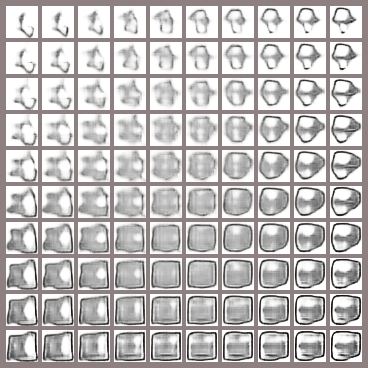

In [170]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))
for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[ - (i % 2) * (x - 4.5) / 3 + ((i + 1) % 2) * (y - 4.5) / 3
                            for i in range(latent_space_depth)]])
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

In [131]:
vec = np.asarray([[np.random.normal() 
                    for _ in range(latent_space_depth)]])
vec.shape

(1, 128)

In [134]:
vec

array([[ 1.2,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ]])

In [135]:
np.asarray([[np.random.normal() 
                    for _ in range(latent_space_depth)]])

array([[ 1.54127268,  0.75542285,  0.02418055,  0.12812252, -0.45038135,
        -0.12498562, -0.50406062,  1.7153789 , -0.36611748, -1.68523352,
        -1.4068772 , -0.62122251, -0.20882113,  0.86702964,  0.56838321,
         0.61278478, -0.56450945, -0.6132218 ,  0.62080908, -0.45884909,
        -0.81596489,  1.90906008,  0.47090321, -0.70723417, -0.08987115,
        -0.98996504,  1.5055198 ,  0.33933324, -0.00727612,  0.53081118,
        -0.92274769,  0.61856344,  0.63260797,  0.15246067,  0.6993734 ,
        -0.81163242, -0.8842845 ,  0.882867  ,  1.17233759, -0.87674041,
        -0.63333666,  0.54598216, -0.68672041,  0.92107567,  0.24558123,
        -0.81178472, -1.54235875,  0.19795614, -0.72898594,  0.60573802,
        -2.44154986,  0.1288156 , -0.83384018,  0.99805866,  0.12594563,
         0.19831904,  1.35020792, -0.82157632,  0.79485373,  0.05986338,
         0.05885011, -0.70727683,  0.1848128 ,  1.28740186, -0.67821694,
        -0.49225507,  0.29651263, -1.28020207, -0.7